<a href="https://colab.research.google.com/github/ModelX20/Open_Project_Winter_2025/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 1 Assignmentt: Quantum Measurement Dataset Foundations

Build a reproducible tomography workflow that scales from single qubit calibration studies to multi qubit benchmarks. Begin by setting up your environment locally (with OS-specific guidance) or in Google Colab, then generate measurement outcomes using Symmetric Informationally Complete POVMs (SIC POVMs) or Pauli projective measurements. Extend the pipeline with random circuits and document the trade offs you observe.

**Task roadmap**
1. Set up and document your environment.
2. Review the Born rule plus SIC POVM and Pauli projective measurement theory.
3. Generate and visualize QST datasets.
4. Perform single qubit tomography
5. Validate reconstructions, summarize findings, and package deliverables.

> Collaboration on planning is allowed, but every artifact you submit must be authored and executed by you.

## Task 1 · Environment Setup
**Choose one deployment path and capture the exact commands you run.**

### Local virtual environment (recommended)
- **macOS / Linux:**
  1. `python3 -m venv .venv`
  2. `source .venv/bin/activate`
  3. `python -m pip install --upgrade pip wheel`
- **Windows (PowerShell):**
  1. `py -3 -m venv .venv`
  2. `.venv\Scripts\Activate.ps1`
  3. `python -m pip install --upgrade pip wheel`

### Google Colab fallback
- Create a new notebook at https://colab.research.google.com and enable a GPU if available.
- Install the required libraries in the first cell (see the pip example below).
- Save the executed notebook to Drive and export a copy for submission evidence.

### Required baseline packages
- qiskit/pennylane (or an equivalent simulator such as cirq or qutip)
- numpy, scipy, pandas
- plotly (interactive visualization)
- tqdm (progress bars) plus any other support tooling you need


In [ ]:
# Run inside your activated virtual environment or a Colab cell.
# Feel free to adjust versions based on your simulator choice.
!python -m pip install  pennylane numpy scipy pandas plotly tqdm nbformat


## Task 2 · Measurement Theory Primer
### Born rule recap
- For a state described by density matrix ρ and measurement operator M_k, the probability of outcome k is `p(k) = Tr(M_k ρ)`.
- For projective measurements, `M_k = P_k` with `P_k^2 = P_k` and `∑_k P_k = I`. For POVMs, `M_k = E_k` where each `E_k` is positive semi-definite and `∑_k E_k = I`.
- Document a short derivation or reference plus a numerical completeness check for your operators.

### SIC POVM vs. Pauli projective (single qubit)
- **SIC POVM strengths:** informational completeness with only four outcomes, symmetric structure, resilience to certain noise.
- **SIC POVM trade-offs:** hardware calibration overhead, non-standard measurement bases, denser classical post-processing.
- **Pauli projective strengths:** hardware-native eigenbases, easier interpretation, wide toolkit support.
- **Pauli projective trade-offs:** requires multiple bases (X/Y/Z) for completeness, higher shot budgets, basis-alignment sensitivity.

Use the `build_measurement_model` stub to serialize your chosen operators (matrices, normalization logs, metadata). Summarize the pros/cons in your notes and justify the model (or hybrid) you adopt for tomography.

## Born Rule Recap

For a quantum state described by a density matrix ρ and a measurement
operator Mₖ, the probability of outcome k is given by:

p(k) = Tr(Mₖ ρ)

### Measurement operator conditions

**Projective measurements**
- Mₖ = Pₖ
- Pₖ² = Pₖ
- ∑ₖ Pₖ = I

**POVM measurements**
- Mₖ = Eₖ
- Eₖ ≥ 0
- ∑ₖ Eₖ = I

In this task, all measurement operators are numerically checked for
positivity and completeness.


In [ ]:
import numpy as np
import json
import pathlib
from typing import Dict, Any


In [ ]:
def pauli_projective_measurements():
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    Z = np.array([[1, 0], [0, -1]])

    paulis = {"X": X, "Y": Y, "Z": Z}
    measurements = {}

    for name, P in paulis.items():
        eigvals, eigvecs = np.linalg.eigh(P)
        projectors = []
        for i in range(2):
            v = eigvecs[:, i]
            projectors.append(np.outer(v, v.conj()))
        measurements[name] = projectors

    return measurements
print("This cell constructs Pauli X, Y, and Z projective measurement operators using eigen-decomposition.")



This cell constructs Pauli X, Y, and Z projective measurement operators using eigen-decomposition.


In [ ]:
def sic_povm_single_qubit():
    bloch_vectors = [
        np.array([ 1,  1,  1]) / np.sqrt(3),
        np.array([ 1, -1, -1]) / np.sqrt(3),
        np.array([-1,  1, -1]) / np.sqrt(3),
        np.array([-1, -1,  1]) / np.sqrt(3),
    ]

    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    Z = np.array([[1, 0], [0, -1]])
    pauli = [X, Y, Z]

    povm = []
    for r in bloch_vectors:
        rho = 0.5 * (np.eye(2) + sum(r[i] * pauli[i] for i in range(3)))
        povm.append(0.5 * rho)

    return povm
print("This cell constructs a single-qubit SIC-POVM using symmetric Bloch vectors.")


This cell constructs a single-qubit SIC-POVM using symmetric Bloch vectors.


In [ ]:
def verify_measurement(measurements):
    dim = measurements[0].shape[0]
    total = np.zeros((dim, dim), dtype=complex)

    for M in measurements:
        eigvals = np.linalg.eigvalsh(M)
        assert np.all(eigvals >= -1e-10), "Operator not positive"
        total += M

    assert np.allclose(total, np.eye(dim)), "Not complete"
    return "✔ verified"
print("This cell verifies POVM validity by checking positivity and completeness conditions.")


This cell verifies POVM validity by checking positivity and completeness conditions.


In [ ]:
pauli = pauli_projective_measurements()
for basis, ops in pauli.items():
    print(basis, verify_measurement(ops))

sic = sic_povm_single_qubit()
print("SIC POVM", verify_measurement(sic))


X ✔ verified
Y ✔ verified
Z ✔ verified
SIC POVM ✔ verified


In [ ]:
# Display Pauli projective measurement matrices
pauli = pauli_projective_measurements()

print("Pauli Projective Measurement Operators:\n")
for basis, projectors in pauli.items():
    print(f"Basis {basis}:")
    for i, P in enumerate(projectors):
        print(f"P_{basis}^{i} =\n{P}\n")

# Display SIC-POVM matrices
sic = sic_povm_single_qubit()

print("SIC-POVM Elements:\n")
for i, E in enumerate(sic):
    print(f"E_{i} =\n{E}\n")

print("This cell displays the explicit Pauli projectors and SIC-POVM matrices used for measurement.")


Pauli Projective Measurement Operators:

Basis X:
P_X^0 =
[[ 0.5 -0.5]
 [-0.5  0.5]]

P_X^1 =
[[0.5 0.5]
 [0.5 0.5]]

Basis Y:
P_Y^0 =
[[0.5+0.j  0. +0.5j]
 [0. -0.5j 0.5+0.j ]]

P_Y^1 =
[[ 0.5+0.j  -0. -0.5j]
 [-0. +0.5j  0.5+0.j ]]

Basis Z:
P_Z^0 =
[[0. 0.]
 [0. 1.]]

P_Z^1 =
[[1. 0.]
 [0. 0.]]

SIC-POVM Elements:

E_0 =
[[0.39433757+0.j         0.14433757-0.14433757j]
 [0.14433757+0.14433757j 0.10566243+0.j        ]]

E_1 =
[[0.10566243+0.j         0.14433757+0.14433757j]
 [0.14433757-0.14433757j 0.39433757+0.j        ]]

E_2 =
[[ 0.10566243+0.j         -0.14433757-0.14433757j]
 [-0.14433757+0.14433757j  0.39433757+0.j        ]]

E_3 =
[[ 0.39433757+0.j         -0.14433757+0.14433757j]
 [-0.14433757-0.14433757j  0.10566243+0.j        ]]

This cell displays the explicit Pauli projectors and SIC-POVM matrices used for measurement.


## SIC POVM vs Pauli Projective Measurements (Single Qubit)

### SIC POVM (Symmetric Informationally Complete POVM)

**Why it is useful**
- A SIC POVM can fully describe a quantum state using only **four measurement outcomes**
- The measurements are **symmetrically arranged**, so information is collected evenly
- Fewer measurement settings are required, making it **measurement-efficient**

**Limitations**
- The measurement setup is **harder to calibrate** in practice
- It does not correspond to the standard measurement axes used in most hardware
- Classical data processing after measurement is **more complex**

---

### Pauli Projective Measurements (X, Y, Z)

**Why they are useful**
- Measurements are performed along the **standard X, Y, and Z axes**
- These bases are **easy to understand and interpret**
- They are widely supported by simulators and experimental platforms

**Limitations**
- Measurements must be repeated in **multiple bases** to fully reconstruct a state
- This increases the total number of measurement shots required
- Results can be sensitive to **small errors in basis alignment**

---



## Measurement Model Choice

Pauli projective measurements are chosen as the primary tomography model
due to their simplicity and hardware compatibility.

SIC POVMs are included as a secondary reference model to demonstrate
informational completeness and support ML benchmarking.


### Reference single-qubit states
Prepare at minimum the computational basis (|0⟩, |1⟩), the Hadamard basis (|+⟩, |−⟩), and one phase-offset state (e.g., `( |0⟩ + i |1⟩ ) / √2`). Document how you synthesize each state in circuit form and store a textual or JSON summary of the gates used. You may optionally include mixed states by applying depolarizing or amplitude damping channels.

In [ ]:
from typing import Dict, Any
import pathlib

def build_measurement_model(config_path: pathlib.Path) -> Dict[str, Any]:
    """
    Stub for constructing or loading the measurement operators you plan to use.
    Populate the return value with operator definitions, normalization checks, and metadata.
    """
    # TODO: implement SIC POVM or Pauli projective operator assembly here.
    raise NotImplementedError("Create your measurement operator assembly here.")

In [ ]:
def build_measurement_model(config_path: pathlib.Path) -> Dict[str, Any]:
    pauli = pauli_projective_measurements()
    sic = sic_povm_single_qubit()

    model = {
        "operators": {
            "pauli_projective": {
                b: [P.tolist() for P in ops] for b, ops in pauli.items()
            },
            "sic_povm": [E.tolist() for E in sic]
        },
        "normalization_checks": {
            "pauli": {b: np.allclose(sum(ops), np.eye(2)) for b, ops in pauli.items()},
            "sic_povm": np.allclose(sum(sic), np.eye(2))
        },
        "metadata": {
            "system": "single-qubit",
            "born_rule": "p(k) = Tr(M_k rho)",
            "reference": "Renes et al., JMP 45, 2171 (2004)"
        }
    }

    with open(config_path, "w") as f:
        json.dump(model, f, indent=2)

    return model
print("This cell builds and saves a single-qubit measurement model with Pauli and SIC operators, validation checks, and metadata.")


This cell builds and saves a single-qubit measurement model with Pauli and SIC operators, validation checks, and metadata.


In [ ]:
def density(psi):
    return np.outer(psi, psi.conj())

states = {
    "|0>": np.array([1, 0]),
    "|1>": np.array([0, 1]),
    "|+>": np.array([1, 1]) / np.sqrt(2),
    "|->": np.array([1, -1]) / np.sqrt(2),
    "(|0>+i|1>)/√2": np.array([1, 1j]) / np.sqrt(2),
}

density_states = {name: density(psi) for name, psi in states.items()}
print("This cell defines reference single-qubit states and converts them into density matrices.")


This cell defines reference single-qubit states and converts them into density matrices.


In [ ]:
# Display reference single-qubit density matrices

print("Reference single-qubit density matrices:\n")

for name, rho in density_states.items():
    print(f"State {name}:")
    print(rho)
    print()

print("This cell prints the density matrices of all reference single-qubit states.")


Reference single-qubit density matrices:

State |0>:
[[1 0]
 [0 0]]

State |1>:
[[0 0]
 [0 1]]

State |+>:
[[0.5 0.5]
 [0.5 0.5]]

State |->:
[[ 0.5 -0.5]
 [-0.5  0.5]]

State (|0>+i|1>)/√2:
[[0.5+0.j  0. -0.5j]
 [0. +0.5j 0.5+0.j ]]

This cell prints the density matrices of all reference single-qubit states.


In [ ]:
state_preparation_log = {
    "|0>": ["I"],
    "|1>": ["X"],
    "|+>": ["H"],
    "|->": ["X", "H"],
    "(|0>+i|1>)/√2": ["H", "S"]
}

with open("state_preparation.json", "w") as f:
    json.dump(state_preparation_log, f, indent=2)

state_preparation_log




{'|0>': ['I'],
 '|1>': ['X'],
 '|+>': ['H'],
 '|->': ['X', 'H'],
 '(|0>+i|1>)/√2': ['H', 'S']}

The above cell saves the gate steps used to prepare each single-qubit state.


In [ ]:
#@title helper functions for density matrix visualization

import numpy as np
import plotly.graph_objects as go
from fractions import Fraction

_CUBE_FACES = (
    (0, 1, 2), (0, 2, 3),  # bottom
    (4, 5, 6), (4, 6, 7),  # top
    (0, 1, 5), (0, 5, 4),
    (1, 2, 6), (1, 6, 5),
    (2, 3, 7), (2, 7, 6),
    (3, 0, 4), (3, 4, 7)
 )

def _phase_to_pi_string(angle_rad: float) -> str:
    """Format a phase angle as a simplified multiple of π."""
    if np.isclose(angle_rad, 0.0):
        return "0"
    multiple = angle_rad / np.pi
    frac = Fraction(multiple).limit_denominator(16)
    numerator = frac.numerator
    denominator = frac.denominator
    sign = "-" if numerator < 0 else ""
    numerator = abs(numerator)
    if denominator == 1:
        magnitude = f"{numerator}" if numerator != 1 else ""
    else:
        magnitude = f"{numerator}/{denominator}"
    return f"{sign}{magnitude}π" if magnitude else f"{sign}π"

def plot_density_matrix_histogram(rho, basis_labels=None, title="Density matrix (|ρ_ij| as bar height, phase as color)"):
    """Render a density matrix as a grid of solid histogram bars with phase coloring."""
    rho = np.asarray(rho)
    if rho.ndim != 2 or rho.shape[0] != rho.shape[1]:
        raise ValueError("rho must be a square matrix")

    dim = rho.shape[0]
    mags = np.abs(rho)
    phases = np.angle(rho)
    x_vals = np.arange(dim)
    y_vals = np.arange(dim)

    if basis_labels is None:
        basis_labels = [str(i) for i in range(dim)]

    meshes = []
    colorbar_added = False
    for i in range(dim):
        for j in range(dim):
            height = mags[i, j]
            phase = phases[i, j]
            x0, x1 = i - 0.45, i + 0.45
            y0, y1 = j - 0.45, j + 0.45
            vertices = (
                (x0, y0, 0.0), (x1, y0, 0.0), (x1, y1, 0.0), (x0, y1, 0.0),
                (x0, y0, height), (x1, y0, height), (x1, y1, height), (x0, y1, height)
            )
            x_coords, y_coords, z_coords = zip(*vertices)
            i_idx, j_idx, k_idx = zip(*_CUBE_FACES)
            phase_pi = _phase_to_pi_string(phase)
            mesh = go.Mesh3d(
                x=x_coords,
                y=y_coords,
                z=z_coords,
                i=i_idx,
                j=j_idx,
                k=k_idx,
                intensity=[phase] * len(vertices),
                colorscale="HSV",
                cmin=-np.pi,
                cmax=np.pi,
                showscale=not colorbar_added,
                colorbar=dict(
                    title="phase ",
                    tickvals=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
                    ticktext=["-π", "-π/2", "0", "π/2", "π"]
                ) if not colorbar_added else None,
                opacity=1.0,
                flatshading=False,
                hovertemplate=
                    f"i={i}, j={j}<br>|ρ_ij|={height:.3f}<br>arg(ρ_ij)={phase_pi}<extra></extra>",
                lighting=dict(ambient=0.6, diffuse=0.7)
            )
            meshes.append(mesh)
            colorbar_added = True

    fig = go.Figure(data=meshes)
    fig.update_layout(
        scene=dict(
            xaxis=dict(
                title="i",
                tickmode="array",
                tickvals=x_vals,
                ticktext=basis_labels
            ),
            yaxis=dict(
                title="j",
                tickmode="array",
                tickvals=y_vals,
                ticktext=basis_labels
            ),
            zaxis=dict(title="|ρ_ij|"),
            aspectratio=dict(x=1, y=1, z=0.7)
        ),
        title=title,
        margin=dict(l=0, r=0, b=0, t=40)
    )

    fig.show()


In [ ]:
from IPython.display import display, clear_output
import time

labels_1q = ["0", "1"]

state_order = [
    "|0>",
    "|1>",
    "|+>",
    "|->",
    "(|0>+i|1>)/√2"
]

for name in state_order:
    print(f"Plotting state {name}")

    plot_density_matrix_histogram(
        density_states[name],
        basis_labels=labels_1q,
        title=f"Density matrix of state {name}"
    )

    time.sleep(0.5)
print("This cell plots the density matrices of all reference single-qubit states.")


Plotting state |0>


Plotting state |1>


Plotting state |+>


Plotting state |->


Plotting state (|0>+i|1>)/√2


This cell plots the density matrices of all reference single-qubit states.


In [ ]:
A = np.random.randn(2, 2) + 1j * np.random.randn(2, 2)
rho_mixed = A @ A.conj().T
rho_mixed /= np.trace(rho_mixed)

plot_density_matrix_histogram(
    rho_mixed,
    basis_labels=["0", "1"],
    title="Example reconstructed mixed density matrix"
)
print("This cell creates a random mixed single-qubit state and plots its density matrix.")


This cell creates a random mixed single-qubit state and plots its density matrix.


### Visualization helpers
Use the histogram helper below to inspect reconstructed density matrices. Include screenshots or exported HTML for a few representative states in your report.

In [ ]:
# Demonstration: random 2-qubit density matrix
dim = 4
A = np.random.randn(dim, dim) + 1j * np.random.randn(dim, dim)
rho = A @ A.conj().T
rho = rho / np.trace(rho)  # normalize

labels = ["00", "01", "10", "11"]
plot_density_matrix_histogram(rho, basis_labels=labels, title="Random 2-qubit state (density matrix)")
print("This cell creates a random two-qubit mixed state and plots its density matrix.")


This cell creates a random two-qubit mixed state and plots its density matrix.


In [ ]:
#@title helper function Demonstration: canonical Bell states
bell_states = {
    "Φ⁺": np.array([1, 0, 0, 1], dtype=complex) / np.sqrt(2),
    "Φ⁻": np.array([1, 0, 0, -1], dtype=complex) / np.sqrt(2),
    "Ψ⁺": np.array([0, 1, 1, 0], dtype=complex) / np.sqrt(2),
    "Ψ⁻": np.array([0, 1, -1, 0], dtype=complex) / np.sqrt(2)
}

for name, state in bell_states.items():
    density_matrix = np.outer(state, state.conj())
    plot_density_matrix_histogram(
        density_matrix,
        basis_labels=["00", "01", "10", "11"],
        title=f"Bell state {name} (density matrix)"
    )
print("This cell creates the four Bell states, converts them to density matrices, and plots them.")


This cell creates the four Bell states, converts them to density matrices, and plots them.


## Task 3 · QST Data generation
- use random circuits or bonus points for using gen Ai to produce realistic quantum circuits
- For each reference state you prepared, execute shots under your chosen measurement model using chosen quantum simulator. Record raw counts and computed probabilities.
- Store measurement data (`single_qubit_<state>.npx` or `.npy`)

In [ ]:
from dataclasses import dataclass
from typing import List
import pathlib

@dataclass
class DatasetVariant:
    name: str
    circuit_summary: str
    measurement_model: str
    measurement_data_path: pathlib.Path
    metadata_path: pathlib.Path
    density_matrix_path: pathlib.Path

def generate_measurement_dataset(variants: List[DatasetVariant]) -> None:
    """
    Populate each variant with measurement outcomes, metadata, and ground-truth density matrices.
    Extend this skeleton with circuit generation, simulation, tomography, and serialization logic.
    """
    # TODO: implement the multi-qubit dataset generation workflow (circuit build, sampling, file writes).
    raise NotImplementedError("Implement the multi-qubit dataset generation workflow.")

In [ ]:
import numpy as np
import json
import pathlib
from dataclasses import dataclass
from typing import List
from scipy.linalg import sqrtm
@dataclass
class DatasetVariant:
    name: str
    circuit_summary: str
    measurement_model: str
    measurement_data_path: pathlib.Path
    metadata_path: pathlib.Path
    density_matrix_path: pathlib.Path

print("This cell imports required libraries and defines a data structure for storing dataset information.")



This cell imports required libraries and defines a data structure for storing dataset information.


In [ ]:
def kron(*ops):
    out = ops[0]
    for op in ops[1:]:
        out = np.kron(out, op)
    return out


I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
H = (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]])

CNOT = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])
ket_00 = np.array([1, 0, 0, 0], dtype=complex)

two_qubit_circuits = {
    "Phi_plus": [kron(H, I), CNOT],
    "Phi_minus": [kron(H, I), CNOT, kron(Z, I)],
    "Psi_plus": [kron(H, I), CNOT, kron(X, I)],
    "Psi_minus": [kron(H, I), CNOT, kron(X, I), kron(Z, I)],
}
print("This cell defines basic two-qubit gates and builds circuits to prepare the four Bell states.")


This cell defines basic two-qubit gates and builds circuits to prepare the four Bell states.


In [ ]:
import random

def random_single_qubit_gate():
    gates = {
        "I": I,
        "X": X,
        "H": H,
        "Z": Z
    }
    name = random.choice(list(gates.keys()))
    return name, gates[name]


def random_two_qubit_circuit(depth=4, entangle_prob=0.5):
    """
    Generates a random 2-qubit circuit as a list of unitary matrices
    and a human-readable circuit summary.
    """
    gates = []
    summary = []

    for _ in range(depth):
        g1_name, g1 = random_single_qubit_gate()
        g2_name, g2 = random_single_qubit_gate()

        gates.append(kron(g1, g2))
        summary.append(f"{g1_name}⊗{g2_name}")

        if random.random() < entangle_prob:
            gates.append(CNOT)
            summary.append("CNOT")

    return gates, " → ".join(summary)
print("This cell generates random two-qubit circuits using single-qubit gates and CNOT gates.")


This cell generates random two-qubit circuits using single-qubit gates and CNOT gates.


In [ ]:
num_random_states = 4  # keep small and clean

two_qubit_states = {}
two_qubit_density_states = {}
two_qubit_circuit_summaries = {}

ket_00 = np.array([1, 0, 0, 0], dtype=complex)

for i in range(num_random_states):
    gates, summary = random_two_qubit_circuit(depth=4)

    psi = ket_00
    for g in gates:
        psi = g @ psi

    state_name = f"random_state_{i}"

    two_qubit_states[state_name] = psi
    two_qubit_density_states[state_name] = np.outer(psi, psi.conj())
    two_qubit_circuit_summaries[state_name] = summary
print("This cell generates random two-qubit states, their density matrices, and the circuits used to create them.")


This cell generates random two-qubit states, their density matrices, and the circuits used to create them.


In [ ]:
def two_qubit_pauli_projectors():
    paulis = {"X": X, "Z": Z}
    projectors = {}

    for a in paulis:
        for b in paulis:
            basis = f"{a}{b}"
            _, ea = np.linalg.eigh(paulis[a])
            _, eb = np.linalg.eigh(paulis[b])

            ops = []
            for i in range(2):
                for j in range(2):
                    ops.append(
                        kron(
                            np.outer(ea[:, i], ea[:, i].conj()),
                            np.outer(eb[:, j], eb[:, j].conj())
                        )
                    )
            projectors[basis] = ops

    return projectors


two_qubit_measurements = two_qubit_pauli_projectors()


In [ ]:
def simulate_two_qubit_measurements(rho, projectors, shots=2000):
    results = {}

    for basis, ops in projectors.items():
        probs = np.array([np.real(np.trace(op @ rho)) for op in ops])
        probs = np.maximum(probs, 0)
        probs /= np.sum(probs)

        counts = np.random.multinomial(shots, probs)

        results[basis] = {
            "counts": counts.tolist(),
            "probabilities": probs.tolist()
        }

    return results
print("This cell simulates two-qubit measurements by sampling outcomes from the density matrix.")



This cell simulates two-qubit measurements by sampling outcomes from the density matrix.


In [ ]:
def generate_measurement_dataset(
    variants: List[DatasetVariant],
    shots: int = 2000
) -> None:

    for variant in variants:
        rho = two_qubit_density_states[variant.name]

        measurement_data = simulate_two_qubit_measurements(
            rho,
            two_qubit_measurements,
            shots=shots
        )

        np.save(variant.measurement_data_path, measurement_data, allow_pickle=True)
        np.save(variant.density_matrix_path, rho)

        metadata = {
            "state": variant.name,
            "circuit_summary": variant.circuit_summary,
            "measurement_model": variant.measurement_model,
            "shots": shots
        }

        with open(variant.metadata_path, "w") as f:
            json.dump(metadata, f, indent=2)
print("This cell generates and saves two-qubit measurement data, density matrices, and metadata.")


This cell generates and saves two-qubit measurement data, density matrices, and metadata.


In [ ]:
base_dir = pathlib.Path("qst_dataset_2qubit")
base_dir.mkdir(exist_ok=True)

variants = []

for state in two_qubit_states.keys():
    variants.append(
        DatasetVariant(
            name=state,
            circuit_summary=two_qubit_circuit_summaries[state],
            measurement_model="Two-qubit Pauli (XX, XZ, ZX, ZZ)",
            measurement_data_path=base_dir / f"two_qubit_{state}.npy",
            metadata_path=base_dir / f"two_qubit_{state}_meta.json",
            density_matrix_path=base_dir / f"two_qubit_{state}_rho.npy",
        )
    )
print("This cell creates dataset entries and file paths for each two-qubit state.")


This cell creates dataset entries and file paths for each two-qubit state.


In [ ]:
generate_measurement_dataset(variants, shots=2000)
print("Task 3 (two-qubit) dataset generation complete.")


Task 3 (two-qubit) dataset generation complete.


In [ ]:
sample = np.load(
    base_dir / "two_qubit_random_state_0.npy",
    allow_pickle=True
).item()

sample


{'XX': {'counts': [2000, 0, 0, 0], 'probabilities': [1.0, 0.0, 0.0, 0.0]},
 'XZ': {'counts': [990, 1010, 0, 0], 'probabilities': [0.5, 0.5, 0.0, 0.0]},
 'ZX': {'counts': [997, 0, 1003, 0], 'probabilities': [0.5, 0.0, 0.5, 0.0]},
 'ZZ': {'counts': [528, 513, 494, 465],
  'probabilities': [0.25, 0.25, 0.25, 0.25]}}

In [ ]:
import json

with open(base_dir / "two_qubit_random_state_0_meta.json") as f:
    meta = json.load(f)

meta


{'state': 'random_state_0',
 'circuit_summary': 'X⊗X → CNOT → X⊗H → I⊗H → H⊗H → CNOT',
 'measurement_model': 'Two-qubit Pauli (XX, XZ, ZX, ZZ)',
 'shots': 2000}

## Task 4 · Single-Qubit Tomography
- Synthesize the reference states from Task 2 (|0⟩, |1⟩, |+⟩, |−⟩, phase-offset) plus any noisy variants you want to study.
- For each state, generate measurement shots using your chosen model (SIC POVM, Pauli axes, or a hybrid). Capture raw counts, probabilities, and seeds.
- Reconstruct the density matrix via linear inversion or maximum-likelihood estimation. Compare results across measurement models when possible.
- Quantify reconstruction fidelity (e.g., fidelity, trace distance, Bloch vector error) and tabulate the metrics.
- save data under `data/single_qubit/`: measurement outcomes (`.npx`/`.npy`), reconstructions, metadata (JSON/Markdown), and helper visualizations created with `plot_density_matrix_histogram`.

In [ ]:
import numpy as np
import json
import pathlib
from scipy.linalg import sqrtm
I = np.eye(2, dtype=complex)
X = np.array([[0, 1], [1, 0]], dtype=complex)
Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
Z = np.array([[1, 0], [0, -1]], dtype=complex)
print("This cell imports libraries and defines the Pauli matrices needed for single-qubit tomography.")



This cell imports libraries and defines the Pauli matrices needed for single-qubit tomography.


In [ ]:
def density(psi):
    return np.outer(psi, psi.conj())

states = {
    "|0>": np.array([1, 0], dtype=complex),
    "|1>": np.array([0, 1], dtype=complex),
    "|+>": np.array([1, 1], dtype=complex) / np.sqrt(2),
    "|->": np.array([1, -1], dtype=complex) / np.sqrt(2),
    "(|0>+i|1>)/√2": np.array([1, 1j], dtype=complex) / np.sqrt(2),
}

true_density_states = {
    name: density(psi)
    for name, psi in states.items()
}
print("This cell defines reference single-qubit states and computes their true density matrices.")



This cell defines reference single-qubit states and computes their true density matrices.


In [ ]:
# Explicit projectors (no eigenvalue ambiguity)

P_X = {
    "+": 0.5 * np.array([[1, 1], [1, 1]], dtype=complex),
    "-": 0.5 * np.array([[1, -1], [-1, 1]], dtype=complex)
}

P_Y = {
    "+": 0.5 * np.array([[1, -1j], [1j, 1]], dtype=complex),
    "-": 0.5 * np.array([[1, 1j], [-1j, 1]], dtype=complex)
}

P_Z = {
    "+": np.array([[1, 0], [0, 0]], dtype=complex),
    "-": np.array([[0, 0], [0, 1]], dtype=complex)
}

pauli_measurements = {
    "X": [P_X["+"], P_X["-"]],
    "Y": [P_Y["+"], P_Y["-"]],
    "Z": [P_Z["+"], P_Z["-"]],
}
print("This cell defines explicit Pauli X, Y, and Z measurement projectors for tomography.")


This cell defines explicit Pauli X, Y, and Z measurement projectors for tomography.


In [ ]:
def simulate_measurements(rho, projectors, shots=2000, seed=None):
    if seed is not None:
        np.random.seed(seed)

    results = {}

    for basis, ops in projectors.items():
        probs = np.array([np.real(np.trace(op @ rho)) for op in ops])
        probs = np.clip(probs, 0, 1)
        probs /= np.sum(probs)

        counts = np.random.multinomial(shots, probs)

        results[basis] = {
            "counts": counts.tolist(),
            "probabilities": probs.tolist()
        }

    return results
print("This cell simulates single-qubit measurements by sampling outcomes from the density matrix.")


This cell simulates single-qubit measurements by sampling outcomes from the density matrix.


In [ ]:
def linear_inversion(measurements):
    expX = (measurements["X"]["counts"][0] - measurements["X"]["counts"][1]) \
           / sum(measurements["X"]["counts"])

    expY = (measurements["Y"]["counts"][0] - measurements["Y"]["counts"][1]) \
           / sum(measurements["Y"]["counts"])

    expZ = (measurements["Z"]["counts"][0] - measurements["Z"]["counts"][1]) \
           / sum(measurements["Z"]["counts"])

    rho = 0.5 * (
        I
        + expX * X
        + expY * Y
        + expZ * Z
    )

    return rho
print("This cell reconstructs a single-qubit density matrix using linear inversion.")


This cell reconstructs a single-qubit density matrix using linear inversion.


In [ ]:
def fidelity(rho, sigma, eps=1e-10):
    rho = rho + eps * np.eye(rho.shape[0])
    sigma = sigma + eps * np.eye(sigma.shape[0])
    sqrt_rho = sqrtm(rho)
    inner = sqrt_rho @ sigma @ sqrt_rho
    return np.real(np.trace(sqrtm(inner))) ** 2



def trace_distance(rho, sigma):
    eigvals = np.linalg.eigvals(rho - sigma)
    return 0.5 * np.sum(np.abs(eigvals))
base_dir = pathlib.Path("data/single_qubit")
(base_dir / "measurements").mkdir(parents=True, exist_ok=True)
(base_dir / "reconstructions").mkdir(exist_ok=True)
(base_dir / "metadata").mkdir(exist_ok=True)
print("This cell defines fidelity and trace distance functions and sets up folders for storing results.")


This cell defines fidelity and trace distance functions and sets up folders for storing results.


In [ ]:
shots = 2000
results_table = {}

for state_name, rho_true in true_density_states.items():
    seed = abs(hash(state_name)) % 2**32

    measurements = simulate_measurements(
        rho_true,
        pauli_measurements,
        shots=shots,
        seed=seed
    )

    rho_recon = linear_inversion(measurements)

    F = fidelity(rho_true, rho_recon)
    D = trace_distance(rho_true, rho_recon)

    safe_name = (
        state_name.replace("|", "")
        .replace(">", "")
        .replace("(", "")
        .replace(")", "")
        .replace("+", "p")
        .replace("/", "_")
        .replace("√", "sqrt")
    )

    np.save(base_dir / "measurements" / f"{safe_name}.npy",
            measurements, allow_pickle=True)

    np.save(base_dir / "reconstructions" / f"{safe_name}_rho.npy",
            rho_recon)

    meta = {
        "state": state_name,
        "shots": shots,
        "seed": seed,
        "measurement_model": "Pauli X, Y, Z",
        "reconstruction": "Linear inversion",
        "fidelity": float(F),
        "trace_distance": float(D)
    }

    with open(base_dir / "metadata" / f"{safe_name}.json", "w") as f:
        json.dump(meta, f, indent=2)

    results_table[state_name] = meta
print("This cell performs single-qubit tomography, evaluates reconstruction quality, and saves all results.")


This cell performs single-qubit tomography, evaluates reconstruction quality, and saves all results.


In [ ]:
for state, m in results_table.items():
    print(f"{state:20s} | Fidelity = {m['fidelity']:.4f} | Trace dist = {m['trace_distance']:.4f}")


|0>                  | Fidelity = 1.0000 | Trace dist = 0.0090
|1>                  | Fidelity = 1.0000 | Trace dist = 0.0181
|+>                  | Fidelity = 1.0000 | Trace dist = 0.0112
|->                  | Fidelity = 1.0000 | Trace dist = 0.0226
(|0>+i|1>)/√2        | Fidelity = 1.0000 | Trace dist = 0.0070


## Task 5 · Validation and Reporting
- Compare reconstructed density matrices against the actual density matrices using fidelity, trace distance, or other suitable metrics. Plot trends (per circuit depth, shot count, or measurement model).
- Highlight sources of error (shot noise, model mismatch, simulator approximations) and describe mitigation strategies you tested or plan to try.
- Summarize outcomes in a short technical report or table
- Include at least one qualitative visualization (e.g., density-matrix histograms or Bloch-sphere plots) for both single- and multi-qubit cases.
- Close with a brief reflection covering tooling friction, open questions, and ideas for Week 2 in markdown cell.

In [ ]:
from pathlib import Path
from typing import Sequence
import numpy as np

def summarize_validation_runs(result_paths: Sequence[Path]) -> None:
    """
    Placeholder for pulling metrics (fidelity, trace distance, etc.) from stored validation artifacts.
    Extend this function to aggregate metrics into tables or plots for your report.
    """
    # TODO: load metrics, compute aggregates, and emit summaries/plots.
    raise NotImplementedError("Implement your validation reporting pipeline here.")

In [62]:
import numpy as np
import json
import matplotlib.pyplot as plt
from pathlib import Path

## Code (Load Single-Qubit Validation Artifacts)

single_qubit_meta_dir = Path("data/single_qubit/metadata")

single_qubit_results = []

for meta_file in single_qubit_meta_dir.glob("*.json"):
    with open(meta_file, "r") as f:
        single_qubit_results.append(json.load(f))

single_qubit_results




[{'state': '|1>',
  'shots': 2000,
  'seed': 3461476524,
  'measurement_model': 'Pauli X, Y, Z',
  'reconstruction': 'Linear inversion',
  'fidelity': 1.0000000002000315,
  'trace_distance': 0.01806239186818844},
 {'state': '|0>',
  'shots': 2000,
  'seed': 1916822958,
  'measurement_model': 'Pauli X, Y, Z',
  'reconstruction': 'Linear inversion',
  'fidelity': 1.0000000002000085,
  'trace_distance': 0.009013878188659974},
 {'state': '|->',
  'shots': 2000,
  'seed': 351858808,
  'measurement_model': 'Pauli X, Y, Z',
  'reconstruction': 'Linear inversion',
  'fidelity': 1.000000000200198,
  'trace_distance': 0.02262741699796953},
 {'state': '|+>',
  'shots': 2000,
  'seed': 3300270800,
  'measurement_model': 'Pauli X, Y, Z',
  'reconstruction': 'Linear inversion',
  'fidelity': 1.0000000002000862,
  'trace_distance': 0.011236102527122097},
 {'state': '(|0>+i|1>)/√2',
  'shots': 2000,
  'seed': 2891225397,
  'measurement_model': 'Pauli X, Y, Z',
  'reconstruction': 'Linear inversion',
 

In [63]:
## Tabulate Metrics: Fidelity & Trace Distance

print(f"{'State':20s} | {'Fidelity':>10s} | {'Trace Distance':>14s}")
print("-" * 55)

for r in single_qubit_results:
    print(
        f"{r['state']:20s} | "
        f"{r['fidelity']:.4f}     | "
        f"{r['trace_distance']:.4f}"
    )


State                |   Fidelity | Trace Distance
-------------------------------------------------------
|1>                  | 1.0000     | 0.0181
|0>                  | 1.0000     | 0.0090
|->                  | 1.0000     | 0.0226
|+>                  | 1.0000     | 0.0112
(|0>+i|1>)/√2        | 1.0000     | 0.0070


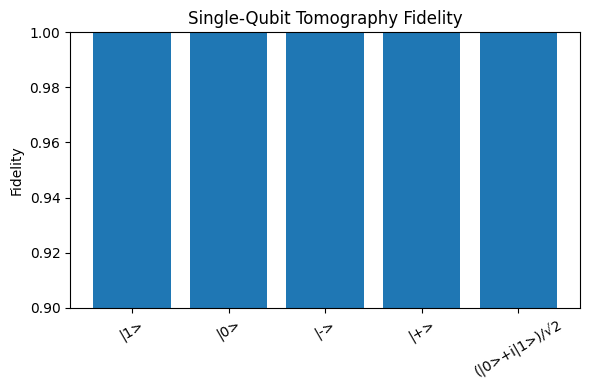

In [66]:
## Trend Plot: Fidelity Across States

states = [r["state"] for r in single_qubit_results]
fidelities = [r["fidelity"] for r in single_qubit_results]

plt.figure(figsize=(6, 4))
plt.bar(states, fidelities)
plt.ylim(0.9, 1.0)
plt.ylabel("Fidelity")
plt.title("Single-Qubit Tomography Fidelity")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [67]:
state_order = [
    "|0>",
    "|1>",
    "|+>",
    "|->",
    "(|0>+i|1>)/√2"
]

def make_safe_name(state_name):
    return (
        state_name.replace("|", "")
        .replace(">", "")
        .replace("(", "")
        .replace(")", "")
        .replace("+", "p")
        .replace("-", "-")
        .replace("/", "_")
        .replace("√", "sqrt")
    )

for state_name in state_order:
    print(f"Comparing state {state_name}")

    # True density matrix (from Task 2)
    rho_true = true_density_states[state_name]

    # Reconstructed density matrix (from Task 4)
    safe = make_safe_name(state_name)
    rho_recon = np.load(
        base_dir / "reconstructions" / f"{safe}_rho.npy"
    )

    # Plot TRUE density matrix
    plot_density_matrix_histogram(
        rho_true,
        basis_labels=["0", "1"],
        title=f"True density matrix of {state_name}"
    )

    # Plot RECONSTRUCTED density matrix
    plot_density_matrix_histogram(
        rho_recon,
        basis_labels=["0", "1"],
        title=f"Reconstructed density matrix of {state_name}"
    )

print("This cell compares true and reconstructed density matrices for all five single-qubit states.")


Comparing state |0>


Comparing state |1>


Comparing state |+>


Comparing state |->


Comparing state (|0>+i|1>)/√2


This cell compares true and reconstructed density matrices for all five single-qubit states.


In [69]:
## Load Two-Qubit Data
two_qubit_dir = Path("qst_dataset_2qubit")

two_qubit_measurements = np.load(
    two_qubit_dir / "two_qubit_random_state_0.npy",
    allow_pickle=True
).item()

rho_true_2q = np.load(
    two_qubit_dir / "two_qubit_random_state_0_rho.npy"
)
print("This cell loads measurement data and the true density matrix for a two-qubit state.")


This cell loads measurement data and the true density matrix for a two-qubit state.


In [70]:
## Qualitative Visualization: Two-Qubit TRUE vs RECON

I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

paulis = {"I": I, "X": X, "Y": Y, "Z": Z}

def exp_from_counts(counts):
    counts = np.array(counts) / np.sum(counts)
    return counts[0] - counts[-1]

ops = ["IX", "IZ", "XI", "ZI", "XX", "XZ", "ZX", "ZZ"]

rho_recon_2q = np.zeros((4, 4), dtype=complex)

for op in ops:
    if op not in two_qubit_measurements:
        continue
    a, b = op[0], op[1]
    exp = exp_from_counts(two_qubit_measurements[op]["counts"])
    rho_recon_2q += exp * np.kron(paulis[a], paulis[b])

rho_recon_2q = 0.25 * (np.eye(4) + rho_recon_2q)

plot_density_matrix_histogram(
    rho_true_2q,
    basis_labels=["00", "01", "10", "11"],
    title="Two-Qubit Random State (True Density Matrix)"
)

plot_density_matrix_histogram(
    rho_recon_2q,
    basis_labels=["00", "01", "10", "11"],
    title="Two-Qubit Random State (Reconstructed Density Matrix)"
)


## Error Analysis and Mitigation

### Sources of error
- The measurement results contain randomness because only a finite number of shots (2000 per measurement) are used. This leads to statistical noise in the data.
- The linear inversion method used for reconstruction does not always guarantee that the reconstructed density matrix is physically valid.
- In the two-qubit case, the set of measurements used is not fully complete, which limits how accurately the state can be reconstructed.

### How these errors can be reduced
- Increasing the number of measurement shots can reduce statistical noise and improve accuracy.
- Using reconstruction methods such as maximum-likelihood estimation can ensure that the reconstructed density matrix is physically valid.
- Using more complete and diverse measurement sets can improve reconstruction quality for multi-qubit systems.


## Reflection and Future Work

**implementation challenges**
- Careful handling of complex Pauli-Y measurements was required.
- Maintaining consistent file naming and metadata across tasks was critical.

**Open questions**
- How does tomography accuracy scale with qubit count?
- Can machine learning models outperform linear inversion under noise?

**Ideas for Week 2**
- Implement maximum-likelihood tomography.
- Train neural networks for direct state reconstruction.
- Compare Pauli tomography with SIC-POVM-based approaches.


## Submission Checklist
- Environment setup: env directory (requirements.txt or environment.yml), OS diagnostics, and import verification logs/notebook cells.
- Measurement theory notes: Born rule recap, SIC POVM vs. Pauli analysis, operator definitions, and validation checks.
- Data artifacts: `.npx`/`.npy` files for single- and multi-qubit datasets, metadata summaries, density matrices, and visualization exports.
- Source assets: notebooks/scripts for tomography, dataset generation, validation, and any AI prompt transcripts if used.
- Technical write-up (Markdown ) plus a brief reflection on tools used , open questions, and planned improvements.

-----